# Access MaNGA H$\alpha$ Velocity Maps

Grab the H$\alpha$ velocity data from the MaNGA data analysis pipeline (DAP) output HYB10 binning. Data can be found at

https://dr16.sdss.org/sas/dr16/manga/spectro/analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/

The Pipe3D value-added catalog can also be compared to the DAP data; see

https://dr16.sdss.org/sas/dr16/manga/spectro/pipe3d/

High-level DAP data can be found in the "DAPALL" files distributed with MaNGA data releases. See

https://data.sdss.org/datamodel/files/MANGA_SPECTRO_ANALYSIS/DRPVER/DAPVER/dapall.html

In [1]:
from rotcurve.io import MaNGA_DAP, MaNGA_HYB10, MaNGA_Pipe3D
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants
from astropy.coordinates import SkyCoord

from photutils import SkyEllipticalAperture

import os

mpl.rc('font', size=12)

## Import Data

Grab the DAP summary file and the output from one plate+IFU. Extract the corresponding summary data.

In [2]:
sas = os.environ['SAS_BASE_DIR']

dapall = MaNGA_DAP('/'.join([sas, 'dr16/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits']))
hyb10 = MaNGA_HYB10('/'.join([sas, 'dr16/manga/spectro/analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/7443/12705/manga-7443-12705-MAPS-HYB10-GAU-MILESHC.fits.gz']))
pip3d = MaNGA_Pipe3D('/'.join([sas, 'dr16/manga/spectro/pipe3d/v2_4_3/2.4.3/7443/manga-7443-12705.Pipe3D.cube.fits.gz']))
dapdat = dapall.get_data(hyb10.plateifu)

a string value was expected. [astropy.wcs.wcs]


### Object Summary Data

Extract the object location and isophotal ellipses (Sersic and Petrosian) from the NASA-Sloan Atlas.

In [3]:
# Object position and distance using NSA Sloan Atlas.
objra, objdec = [float(dapdat[_]) for _ in ['OBJRA', 'OBJDEC']]
z = float(dapdat['NSA_Z'])
D_L = float(dapdat['LDIST_NSA_Z'])
D_A = float(dapdat['ADIST_NSA_Z'])

# Petrosian isophotal ellipse axis ratio, angle (E of N), and 50% light radius in r band.
ba_p = float(dapdat['NSA_ELPETRO_BA'])
phi_p = float(dapdat['NSA_ELPETRO_PHI'])
th50_p = float(dapdat['NSA_ELPETRO_TH50_R'])

# Sersic isophotal ellipse axis ratio, angle (E of N), 50% light radius, and index.
ba_s = float(dapdat['NSA_SERSIC_BA'])
phi_s = float(dapdat['NSA_SERSIC_PHI'])
th50_s = float(dapdat['NSA_SERSIC_TH50'])
n_s = float(dapdat['NSA_SERSIC_N'])

# Ellipse radius covering 90% of elliptical annuli.
rcov90 = float(dapdat['RCOV90'])

## Plot H$\alpha$ Velocity Map

### HYB10 Output

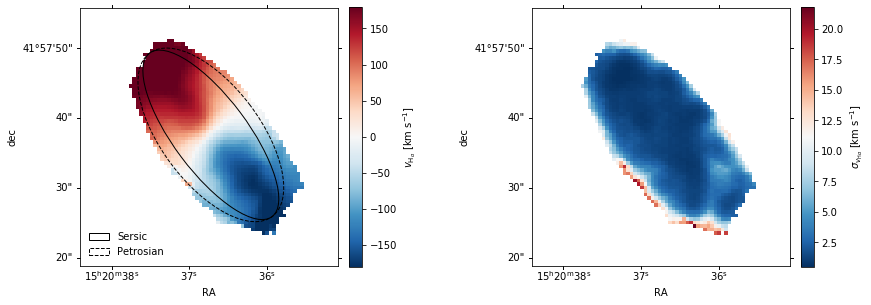

In [4]:
fig, axes = plt.subplots(1,2, figsize=(12,4.5),
                         sharex=True, sharey=True,
                         subplot_kw={'projection':hyb10.wcs},
                         gridspec_kw={'wspace':0.6})
ax = axes[0]
im = ax.imshow(hyb10.vHa, origin='lower', cmap='RdBu_r', vmin=-180, vmax=180)
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label(r'$v_{\mathrm{H}_\alpha}$ [km s$^{-1}$]')
ax.set(aspect='equal',
       xlabel=r'RA',
       ylabel=r'dec')

# Plot the Sersic isophotal 90% coverage ellipse.
aper = SkyEllipticalAperture(SkyCoord(objra*u.degree, objdec*u.degree, frame='icrs'),
                             rcov90*u.arcsec, rcov90*ba_s*u.arcsec,
                             (phi_s)*u.degree)
pix = aper.to_pixel(hyb10.wcs)
pix.plot(axes=ax, label='Sersic')

# Plot the Petrosian isophotal 90% coverage ellipse.
aper = SkyEllipticalAperture(SkyCoord(objra*u.degree, objdec*u.degree, frame='icrs'),
                             rcov90*u.arcsec, rcov90*ba_p*u.arcsec,
                             (phi_p)*u.degree)
pix = aper.to_pixel(hyb10.wcs)
pix.plot(axes=ax, ls='--', label='Petrosian')

leg = ax.legend()
leg.get_frame().set_linewidth(0)

ax = axes[1]
im = ax.imshow(np.sqrt(1./hyb10.ivar_vHa), origin='lower', cmap='RdBu_r')
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label(r'$\sigma_{v_{\mathrm{H}\alpha}}$ [km s$^{-1}$]')
ax.set(aspect='equal',
       xlabel=r'RA',
       ylabel=r'dec')

fig.subplots_adjust(left=0.125, bottom=0.125, right=0.975, top=0.95)

### Pipe3D Output

Note that the Pipe3D H$\alpha$ velocity map does not have the systematic velocity estimated or subtracted. We can try to get it by grabbing the redshift of the object from the NASA-Sloan Atlas and assuming that it is a reasonable average for the entire galaxy.

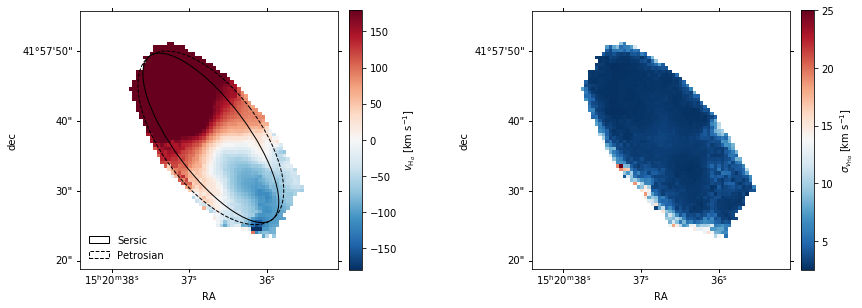

In [5]:
fig, axes = plt.subplots(1,2, figsize=(12,4.5),
                         sharex=True, sharey=True,
                         subplot_kw={'projection':hyb10.wcs},
                         gridspec_kw={'wspace':0.6})
ax = axes[0]

# Mask the Pipe3D data using the DAP mask.
# Note that the Ha velocity map does not have v_sys subtracted out.
v_sys = (constants.c * z).to('km/s').value
vHa = np.ma.masked_array(pip3d.vHa - v_sys, mask=hyb10.mask_vHa)

im = ax.imshow(vHa, origin='lower', cmap='RdBu_r', vmin=-180, vmax=180)
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label(r'$v_{\mathrm{H}_\alpha}$ [km s$^{-1}$]')
ax.set(aspect='equal',
       xlabel=r'RA',
       ylabel=r'dec')

# Plot the Sersic isophotal 90% coverage ellipse.
aper = SkyEllipticalAperture(SkyCoord(objra*u.degree, objdec*u.degree, frame='icrs'),
                             rcov90*u.arcsec, rcov90*ba_s*u.arcsec,
                             (phi_s)*u.degree)
pix = aper.to_pixel(hyb10.wcs)
pix.plot(axes=ax, label='Sersic')

# Plot the Petrosian isophotal 90% coverage ellipse.
aper = SkyEllipticalAperture(SkyCoord(objra*u.degree, objdec*u.degree, frame='icrs'),
                             rcov90*u.arcsec, rcov90*ba_p*u.arcsec,
                             (phi_p)*u.degree)
pix = aper.to_pixel(hyb10.wcs)
pix.plot(axes=ax, ls='--', label='Petrosian')

leg = ax.legend()
leg.get_frame().set_linewidth(0)

ax = axes[1]

# Mask the Pipe3D data using the DAP mask.
dvHa = np.ma.masked_array(pip3d.dvHa, mask=hyb10.mask_vHa)

im = ax.imshow(dvHa, origin='lower', cmap='RdBu_r')
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label(r'$\sigma_{v_{\mathrm{H}\alpha}}$ [km s$^{-1}$]')
ax.set(aspect='equal',
       xlabel=r'RA',
       ylabel=r'dec')

fig.subplots_adjust(left=0.125, bottom=0.125, right=0.975, top=0.95)

### Difference between HYB10 and Pipe3D

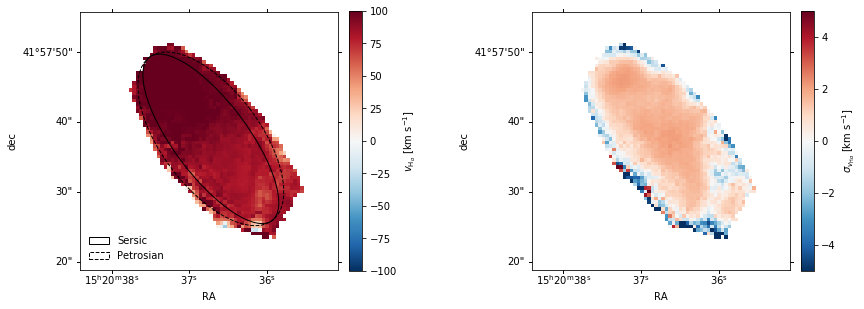

In [6]:
fig, axes = plt.subplots(1,2, figsize=(12,4.5),
                         sharex=True, sharey=True,
                         subplot_kw={'projection':hyb10.wcs},
                         gridspec_kw={'wspace':0.6})
ax = axes[0]
im = ax.imshow(vHa - hyb10.vHa, origin='lower', cmap='RdBu_r',
               vmin=-100, vmax=100)
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label(r'$v_{\mathrm{H}_\alpha}$ [km s$^{-1}$]')
ax.set(aspect='equal',
       xlabel=r'RA',
       ylabel=r'dec')

# Plot the Sersic isophotal 90% coverage ellipse.
aper = SkyEllipticalAperture(SkyCoord(objra*u.degree, objdec*u.degree, frame='icrs'),
                             rcov90*u.arcsec, rcov90*ba_s*u.arcsec,
                             (phi_s)*u.degree)
pix = aper.to_pixel(hyb10.wcs)
pix.plot(axes=ax, label='Sersic')

# Plot the Petrosian isophotal 90% coverage ellipse.
aper = SkyEllipticalAperture(SkyCoord(objra*u.degree, objdec*u.degree, frame='icrs'),
                             rcov90*u.arcsec, rcov90*ba_p*u.arcsec,
                             (phi_p)*u.degree)
pix = aper.to_pixel(hyb10.wcs)
pix.plot(axes=ax, ls='--', label='Petrosian')

leg = ax.legend()
leg.get_frame().set_linewidth(0)

ax = axes[1]
im = ax.imshow(dvHa - np.sqrt(1./hyb10.ivar_vHa), origin='lower', cmap='RdBu_r',
               vmin=-5, vmax=5)
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label(r'$\sigma_{v_{\mathrm{H}\alpha}}$ [km s$^{-1}$]')
ax.set(aspect='equal',
       xlabel=r'RA',
       ylabel=r'dec')

fig.subplots_adjust(left=0.125, bottom=0.125, right=0.975, top=0.95)